In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dataset class for Fact-Check Dataset
def map_label(label):
    if label == "Supports":
        return 0
    elif label == "Refutes":
        return 1
    elif label == "Not_Enough_Information":  # Not enough information
        return 2
    else:
        raise ValueError(f"Invalid label: {label}")

In [3]:
class FactCheckDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        claim = row["claim"]
        evidence = row["evidence"]
        label = map_label(row["gold_label"])

        # Tokenize claim and evidence
        inputs = self.tokenizer(
            text=claim,
            text_pair=evidence,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [4]:
# Model definition
class FactCheckModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(FactCheckModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)
        return logits

In [5]:
# Load data files
train_data = pd.read_csv("/kaggle/input/viwikifcdataset/train_final_viwikifc.csv")
dev_data = pd.read_csv("/kaggle/input/viwikifcdataset/dev_final_viwikifc.csv")
test_data = pd.read_csv("/kaggle/input/viwikifcdataset/test_final_viwikifc.csv")

In [6]:
# Pre-trained model and tokenizer
MODEL_NAME = "FPTAI/vibert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Prepare datasets
train_dataset = FactCheckDataset(train_data, tokenizer, max_len=128)
dev_dataset = FactCheckDataset(dev_data, tokenizer, max_len=128)
test_dataset = FactCheckDataset(test_data, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [8]:
# Initialize model
model = FactCheckModel(model_name=MODEL_NAME, num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

pytorch_model.bin:   0%|          | 0.00/581M [00:00<?, ?B/s]

In [9]:
# Training function
def train_model(model, train_loader, dev_loader, optimizer, loss_fn, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}")

In [10]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=["Supports", "Refutes", "Not_Enough_Information"]))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Supports", "Refutes", "Not_Enough_Information"],
                yticklabels=["Supports", "Refutes", "Not_Enough_Information"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [16]:
# Train the model
train_model(model, train_loader, dev_loader, optimizer, loss_fn, epochs=5)

Epoch 1, Train Loss: 0.5848
Epoch 2, Train Loss: 0.5855
Epoch 3, Train Loss: 0.5824
Epoch 4, Train Loss: 0.5841
Epoch 5, Train Loss: 0.5870


                        precision    recall  f1-score   support

              Supports       0.64      0.63      0.63       708
               Refutes       0.62      0.61      0.61       706
Not_Enough_Information       0.72      0.74      0.73       677

              accuracy                           0.66      2091
             macro avg       0.66      0.66      0.66      2091
          weighted avg       0.66      0.66      0.66      2091



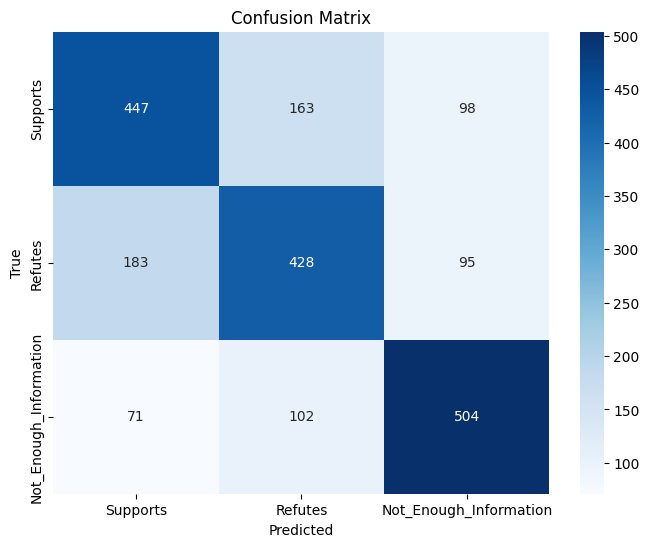

In [17]:
# Test the model
evaluate_model(model, test_loader)

In [18]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tính toán các thang đo hiệu suất
def compute_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    metrics = {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "F1-Score (Macro)": f1_score(all_labels, all_preds, average="macro"),
        "F1-Score (Micro)": f1_score(all_labels, all_preds, average="micro"),
        "Precision (Macro)": precision_score(all_labels, all_preds, average="macro"),
        "Recall (Macro)": recall_score(all_labels, all_preds, average="macro"),
    }

    # ROC-AUC và PR-AUC theo từng lớp
    roc_auc = {}
    pr_auc = {}
    for i in range(3):  # 3 lớp: Supports, Refutes, Not_Enough_Information
        roc_auc[f"Class {i}"] = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
        pr_auc[f"Class {i}"] = average_precision_score((all_labels == i).astype(int), all_probs[:, i])

    metrics["ROC-AUC (Class-wise)"] = roc_auc
    metrics["PR-AUC (Class-wise)"] = pr_auc

    return metrics, all_labels, all_preds, all_probs

In [19]:
# Hiển thị Confusion Matrix
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Supports", "Refutes", "Not_Enough_Information"],
        yticklabels=["Supports", "Refutes", "Not_Enough_Information"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Vẽ ROC Curve
def plot_roc_curve(all_labels, all_probs):
    plt.figure(figsize=(10, 8))
    for i in range(3):  # 3 lớp
        fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC: {roc_auc_score((all_labels == i).astype(int), all_probs[:, i]):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


# Vẽ Precision-Recall Curve
def plot_pr_curve(all_labels, all_probs):
    plt.figure(figsize=(10, 8))
    for i in range(3):  # 3 lớp
        precision, recall, _ = precision_recall_curve((all_labels == i).astype(int), all_probs[:, i])
        plt.plot(recall, precision, label=f"Class {i} (AP: {average_precision_score((all_labels == i).astype(int), all_probs[:, i]):.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

Performance Metrics:
Accuracy: 0.6595
F1-Score (Macro): 0.6600
F1-Score (Micro): 0.6595
Precision (Macro): 0.6595
Recall (Macro): 0.6607
ROC-AUC (Class-wise):
  Class 0: 0.8229
  Class 1: 0.8044
  Class 2: 0.8861
PR-AUC (Class-wise):
  Class 0: 0.7069
  Class 1: 0.6931
  Class 2: 0.8141


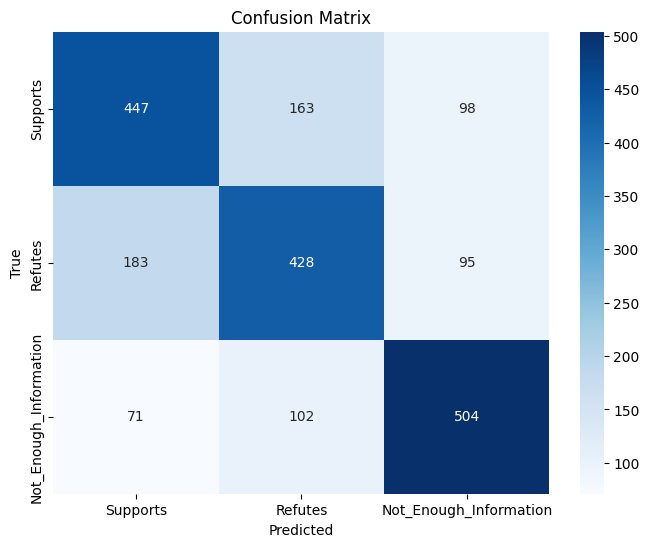

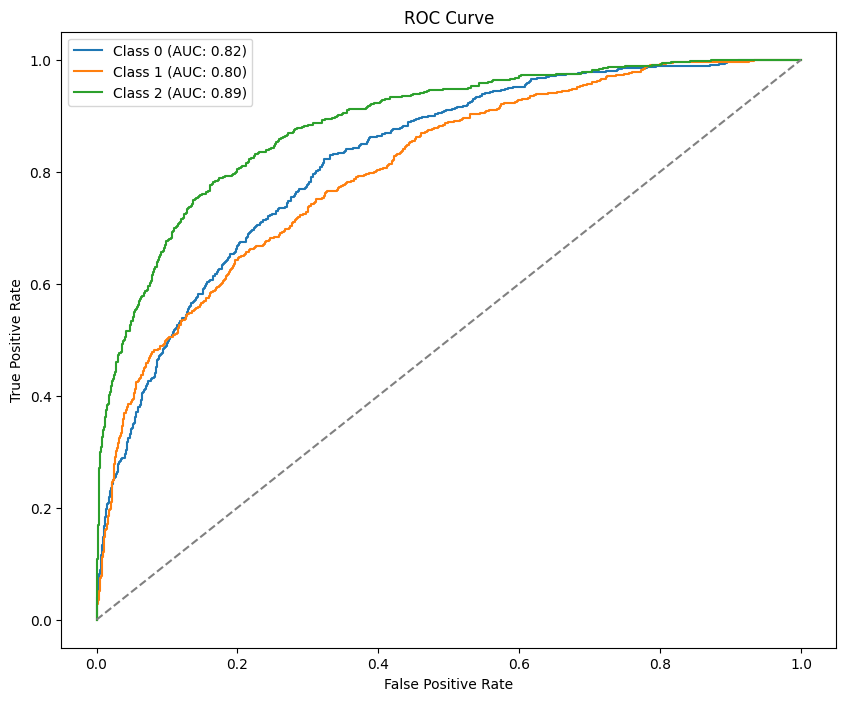

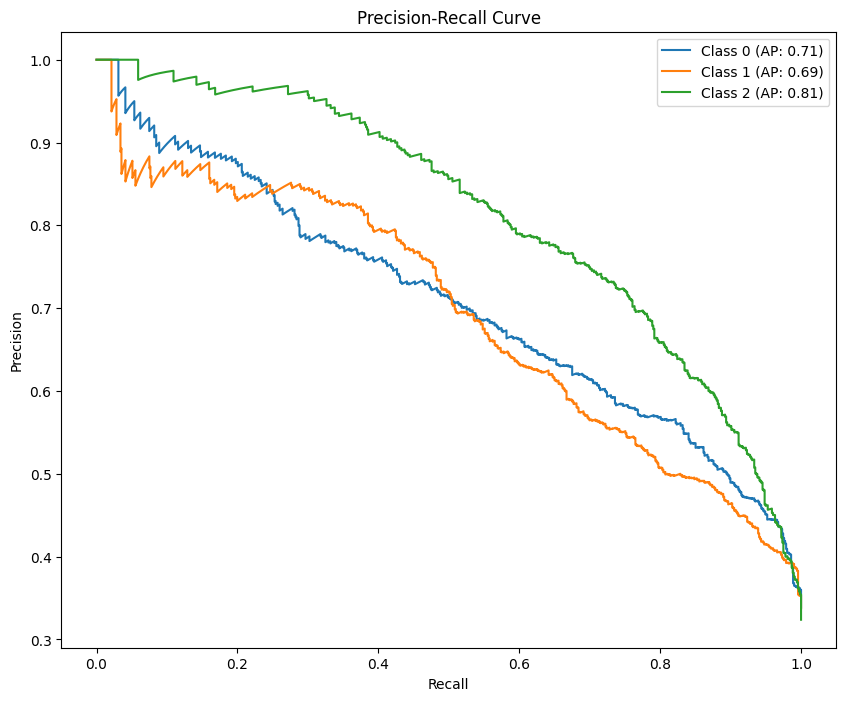

In [20]:
# Đánh giá mô hình
metrics, all_labels, all_preds, all_probs = compute_metrics(model, test_loader)

# In các thang đo hiệu suất
print("Performance Metrics:")
for metric, value in metrics.items():
    if isinstance(value, dict):  # Thang đo theo từng lớp
        print(f"{metric}:")
        for cls, score in value.items():
            print(f"  {cls}: {score:.4f}")
    else:
        print(f"{metric}: {value:.4f}")

# Hiển thị Confusion Matrix
plot_confusion_matrix(all_labels, all_preds)

# Hiển thị ROC Curve
plot_roc_curve(all_labels, all_probs)

# Hiển thị Precision-Recall Curve
plot_pr_curve(all_labels, all_probs)